In [26]:
import matplotlib.pyplot as plt
import numpy as np

import nnfs
from nnfs.datasets import vertical_data, spiral_data

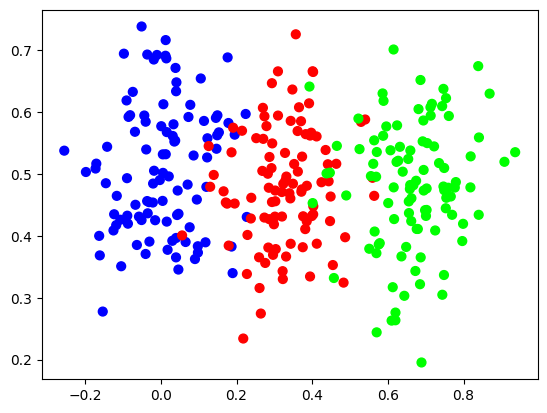

In [5]:
nnfs.init()

X, y = vertical_data(samples=100, classes=3)

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.show()

In [10]:
class Layer_Dense:

    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases


In [11]:
class Activation_ReLU:

    def forward(self, inputs):
        self.output = np.maximum(0, inputs)

In [13]:
class Activation_Softmax:

    def forward(self, inputs):

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Get normalized values
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities

In [14]:
# Common Loss Class
class Loss:

    # Calculate the data and regularization losses
    def calculate(self, inputs, y):
        sample_losses = self.forward(inputs, y)

        data_loss = np.mean(sample_losses)

        return data_loss

# Cross-entropy Loss
class Loss_CategoricalCrossentropy(Loss):

    def forward(self, y_pred, y_true):

        # number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any values
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values - only if categorical values
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        if len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        negative_log_likelihoods = -np.log(correct_confidences)

        return negative_log_likelihoods

### A Simple neural network

In [20]:
# Create model
dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossentropy()


In [21]:
# Create some variables to track the best loss and the associated weights and biases:

lowest_loss = 9999999 # some initial value
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_denes2_weights = dense2.weights.copy()
best_dense2_weights = dense2.biases.copy()

We initialized the loss to a large value and will decrease it when a new, lowe, loss is found. We are also copying weights and biases (`copy()` ensures a full copy instead of a reference to the object). Now we iterate as many times as desired, pick random values for weights and biases, and save the weights and biases if they generate the lowest-seen loss:

In [23]:
for iteration in range(10000):

    # Generate a new set of weights for iteration
    dense1.weights = 0.05 * np.random.randn(2, 3)
    dense1.biases = 0.05 * np.random.randn(1, 3)
    dense2.weights = 0.05 * np.random.randn(3, 3)
    dense2.biases = 0.05 * np.random.randn(1, 3)

    # Perform a forward pass of the training data through this layer
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    # Perform a forward pass through loss function
    # it takes the output of second activation here and return loss
    loss = loss_function.calculate(activation2.output, y)

    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(predictions==y)


    # If loss is smaller - print and save weights and biases aside
    if loss < lowest_loss:
        print('New set of weights found, iteration: ', iteration,
              'loss:', loss, 'acc:', accuracy)
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss


New set of weights found, iteration:  0 loss: 1.1010591 acc: 0.3333333333333333
New set of weights found, iteration:  1 loss: 1.0990437 acc: 0.3333333333333333
New set of weights found, iteration:  2 loss: 1.0988637 acc: 0.3333333333333333
New set of weights found, iteration:  10 loss: 1.0987809 acc: 0.3333333333333333
New set of weights found, iteration:  19 loss: 1.0983545 acc: 0.33666666666666667
New set of weights found, iteration:  29 loss: 1.0979015 acc: 0.3333333333333333
New set of weights found, iteration:  81 loss: 1.0969089 acc: 0.3333333333333333
New set of weights found, iteration:  1189 loss: 1.0964065 acc: 0.3333333333333333
New set of weights found, iteration:  3873 loss: 1.0963326 acc: 0.3333333333333333
New set of weights found, iteration:  5417 loss: 1.0958136 acc: 0.5833333333333334


Even with this basic dataset, we see that randomly searching for weight and bias combinations will take far too long to be an acceptable method. Another idea might be, instead of setting parameters with randomly-chosen values each iteration, apply a fraction of these values to parameters. With this, weights will be updated from what currently yields us the lowest loss instead of aimlessly randomly. If the adjustment decreases loss, we will make it the new point to adjust from. If loss insread increases due to the adjustment, then we will revert to the previous point. Using similar code from earlier, we will first chnage from randomly selecting weights and biases to randomly adjusting them:

In [24]:
X, y = vertical_data(samples=100, classes=3)

# Create model
dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()

# create loss function
loss_function = Loss_CategoricalCrossentropy()

# Helper variables
lowest_loss = 9999999 # some initial value
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(10000):

    # Update weights with some small random values
    dense1.weights += 0.05 * np.random.randn(2, 3)
    dense1.biases += 0.05 * np.random.randn(1, 3)
    dense2.weights += 0.05 * np.random.randn(3, 3)
    dense2.biases += 0.05 * np.random.randn(1, 3)

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    loss = loss_function.calculate(activation2.output, y)

    # Calculate accuracy from output of activation2 and targets
    # calculate values along second axis
    prediction = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(prediction==y)

    # If loss is smaller - print and save weights and biases aside
    if loss < lowest_loss:
        print('New set of weights found, iteration:', iteration,
              'loss:', loss, 'acc:', accuracy)
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss

    # Revert weights and biases
    else:
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy()


New set of weights found, iteration: 0 loss: 1.1246568 acc: 0.3333333333333333
New set of weights found, iteration: 1 loss: 1.0997745 acc: 0.3333333333333333
New set of weights found, iteration: 3 loss: 1.0750496 acc: 0.3333333333333333
New set of weights found, iteration: 8 loss: 1.0623692 acc: 0.35333333333333333
New set of weights found, iteration: 9 loss: 1.0590868 acc: 0.38333333333333336
New set of weights found, iteration: 19 loss: 1.0576719 acc: 0.36666666666666664
New set of weights found, iteration: 22 loss: 1.0556775 acc: 0.3333333333333333
New set of weights found, iteration: 23 loss: 1.0497707 acc: 0.3333333333333333
New set of weights found, iteration: 25 loss: 1.0450425 acc: 0.3333333333333333
New set of weights found, iteration: 26 loss: 1.0377063 acc: 0.3333333333333333
New set of weights found, iteration: 29 loss: 1.0331053 acc: 0.38666666666666666
New set of weights found, iteration: 30 loss: 1.0302671 acc: 0.34
New set of weights found, iteration: 32 loss: 1.0277665

In [27]:
# Try this method with the spiral data set
X, y = spiral_data(samples=100, classes=3)

# Create model
dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()

# create loss function
loss_function = Loss_CategoricalCrossentropy()

# Helper variables
lowest_loss = 9999999 # some initial value
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(10000):

    # Update weights with some small random values
    dense1.weights += 0.05 * np.random.randn(2, 3)
    dense1.biases += 0.05 * np.random.randn(1, 3)
    dense2.weights += 0.05 * np.random.randn(3, 3)
    dense2.biases += 0.05 * np.random.randn(1, 3)

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    loss = loss_function.calculate(activation2.output, y)

    # Calculate accuracy from output of activation2 and targets
    # calculate values along second axis
    prediction = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(prediction==y)

    # If loss is smaller - print and save weights and biases aside
    if loss < lowest_loss:
        print('New set of weights found, iteration:', iteration,
              'loss:', loss, 'acc:', accuracy)
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss

    # Revert weights and biases
    else:
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy()


New set of weights found, iteration: 0 loss: 1.1126924 acc: 0.3566666666666667
New set of weights found, iteration: 1 loss: 1.1066271 acc: 0.34
New set of weights found, iteration: 3 loss: 1.1047256 acc: 0.35333333333333333
New set of weights found, iteration: 8 loss: 1.0971277 acc: 0.3466666666666667
New set of weights found, iteration: 9 loss: 1.0947251 acc: 0.3566666666666667
New set of weights found, iteration: 11 loss: 1.0946784 acc: 0.4
New set of weights found, iteration: 16 loss: 1.0940802 acc: 0.39666666666666667
New set of weights found, iteration: 26 loss: 1.0933269 acc: 0.4
New set of weights found, iteration: 34 loss: 1.0920497 acc: 0.4
New set of weights found, iteration: 37 loss: 1.0892342 acc: 0.4033333333333333
New set of weights found, iteration: 40 loss: 1.0876782 acc: 0.41
New set of weights found, iteration: 41 loss: 1.0875462 acc: 0.41
New set of weights found, iteration: 46 loss: 1.0875095 acc: 0.41333333333333333
New set of weights found, iteration: 49 loss: 1.0

# Derivative

### The Impact of a Parameter on the Output

Let's tart with a simple function and discover what is meant by "impact".
A very simple function y=2x, which takes `x` as an input:

In [28]:
def f(x):
    return 2*x

In [34]:
x = np.array(range(5))
y = f(x)

x, y

(array([0, 1, 2, 3, 4]), array([0, 2, 4, 6, 8]))

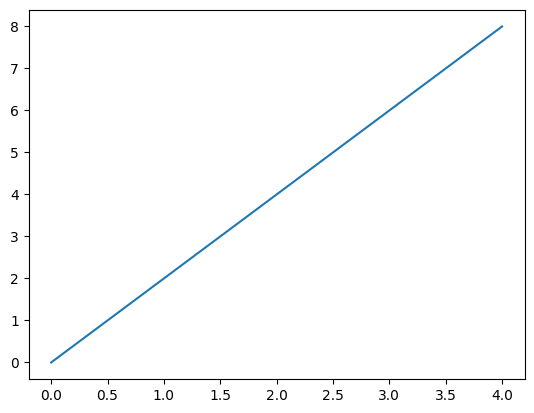

In [35]:
plt.plot(x, y)
plt.show()

## The Slope

It is change in y divided by change in x, or in math - `delta y` divided by `delta x`. So, the slope of this line is 2. In another word, the measure of the impact that `x` has on `y` is 2.

In [39]:
(y[2] - y[1]) / (x[2] - x[1])

np.float64(2.0)

In [40]:
# What about a nonlinear function such as:
def f(x):
    return 2*x**2

In [43]:
y = f(x)
x, y

(array([0, 1, 2, 3, 4]), array([ 0,  2,  8, 18, 32]))

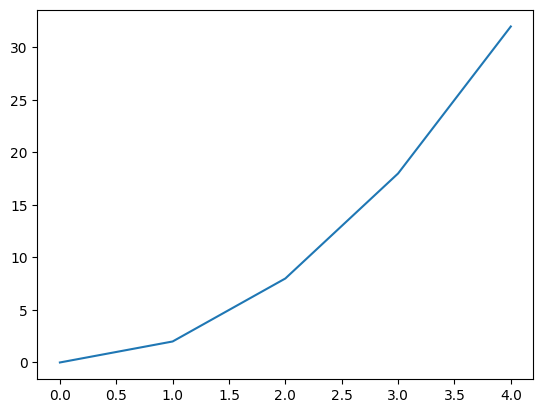

In [44]:
plt.plot(x, y)
plt.show()

In [45]:
(y[1] - y[0]) / (x[1] - x[0])

np.float64(2.0)

In [46]:
(y[2] - y[1]) / (x[2] - x[1])

np.float64(6.0)

In [47]:
(y[3] - y[2]) / (x[3] - x[2])

np.float64(10.0)

How might we measure the impact that x has on y in this nonlinear function? Calculus proposes that we measure the slope of the tangent line at x (for a specific input value to the function),
giving us the instantaneous slope (slope at this point), which is the derivative. The tangent line
is created by drawing a line between two points that are “infinitely close” on a curve, but this
curve has to be differentiable at the derivation point. This means that it has to be continuous and
smooth (we cannot calculate the slope at something that we could describe as a “sharp corner,”
since it contains an infinite number of slopes). Then, because this is a curve, there is no single
slope. Slope depends on where we measure it. To give an immediate example, we can
approximate a derivative of the function at x by using this point and another one also taken at x,
but with a very small delta added to it, such as 0.0001. This number is a common choice as it does
not introduce too large an error (when estimating the derivative) or cause the whole expression to
be numerically unstable (Δx might round to 0 due to floating-point number resolution). This lets
us perform the same calculation for the slope as before, but on two points that are very close to
each other, resulting in a good approximation of a slope at x:

In [48]:
p2_delta = 0.0001
x1 = 1
x2 = x1 + p2_delta # add delta
y1 = f(x1) # result at the derivation point
y2 = f(x2) # result at the other, close point
approximate_derivative = (y2-y1)/(x2-x1)
print(approximate_derivative)

4.0001999999987845


## The Numerical Derivative

This method of calculating the derivative is called **numberical differentiation**--calculating the slope of the tangent line using two `infinitely` close points, or as with the code solution--calculating the slope of a tangent line made from two points that were "sufficiently close"

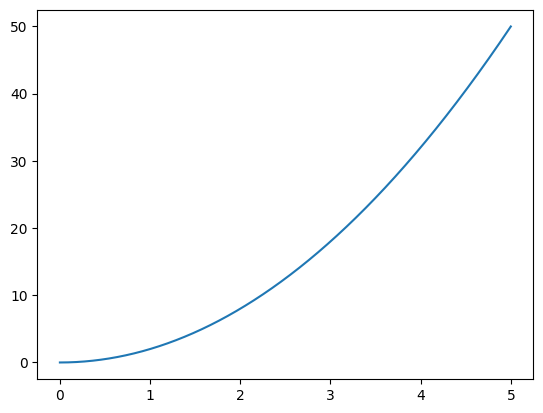

In [49]:
x = np.arange(0, 5, 0.001)
y = f(x)

plt.plot(x, y)
plt.show()

(2, 8) (2.0001, 8.000800020000002)
-8.00039999999757
[1.1, 2, 2.9]
[0.7998200000010929, 7.999999999999998, 15.200179999998904]
Approximate derivative for f(x) where x = 2 is 8.000199999998785


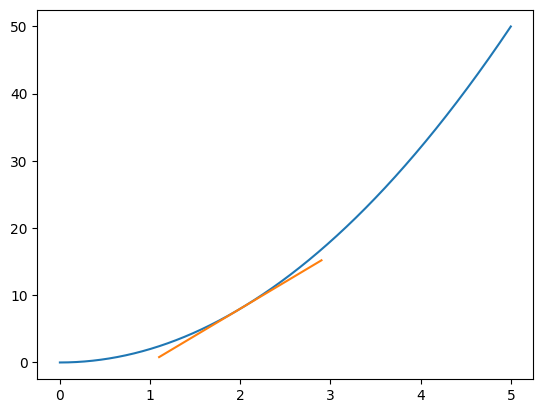

In [58]:
plt.plot(x, y)

# The point and the "close enough" point
p2_delta = 0.0001
x1 = 2
x2 = x1 + p2_delta

y1 = f(x1)
y2 = f(x2)

print((x1, y1), (x2, y2))

# Derivative approximation and y-intercept for the tangent line
approximate_derivative = (y2-y1) / (x2-x1)
b = y2 - approximate_derivative * x2
print(b)

# We put the tangent line calculation into a function so we can call
# it multiple times for different values of x
# approximate_derivative and b are constant for given function
# thus calculated once above this function
def tangent_line(x):
    return approximate_derivative * x + b

# plotting the tangent line
# +/- 0.9 to draw the tangent line on our graph
# then we calculate the y for given x using the tangent line function
# Matplotlib will draw a line for us through these points
to_plot = [x1-0.9, x1, x1+0.9]
print(to_plot)
plt.plot(to_plot, [tangent_line(i) for i in to_plot])
print([tangent_line(i) for i in to_plot])

print(f'Approximate derivative for f(x) where x = {x1} is {approximate_derivative}')
plt.show()

The slope of the tangent line tells the impact that `x` has on this function at a particular point, in this case `x1 = 2`, referred to as the **instantaneous rate of change**. We will use this concept to determine the effect of a specific weight or bias on the overall loss function given a sample

(0, 0) (0.0001, 2e-08)
Approximate derivative for f(x) where x = 0 is 0.00019999999999999998
(1, 2) (1.0001, 2.00040002)
Approximate derivative for f(x) where x = 1 is 4.0001999999987845
(2, 8) (2.0001, 8.000800020000002)
Approximate derivative for f(x) where x = 2 is 8.000199999998785
(3, 18) (3.0001, 18.001200020000002)
Approximate derivative for f(x) where x = 3 is 12.000199999998785
(4, 32) (4.0001, 32.00160002)
Approximate derivative for f(x) where x = 4 is 16.000200000016548


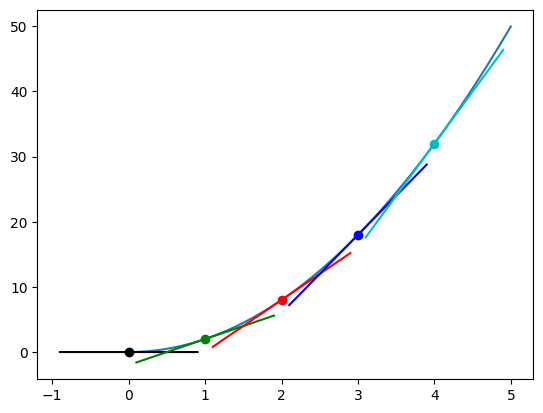

In [60]:
def f(x):
    return 2 * x**2

x = np.array(np.arange(0, 5, 0.001))
y = f(x)

plt.plot(x, y)

colors = ['k', 'g', 'r', 'b', 'c']

def approximate_tangent_line(x, approximate_derivative):
    return (approximate_derivative * x) + b

for i in range(5):
    p2_delta = 0.0001
    x1 = i
    x2 = i + p2_delta

    y1 = f(x1)
    y2 = f(x2)

    print((x1, y1), (x2, y2))

    approximate_derivative = (y2 - y1) / (x2 - x1)
    b = y2 - approximate_derivative * x2

    to_plot = [x1-0.9, x1, x1+0.9]

    plt.scatter(x1, y1, c=colors[i])
    plt.plot([point for point in to_plot],
             [approximate_tangent_line(point, approximate_derivative)
              for point in to_plot],
             c=colors[i])

    print(f"Approximate derivative for f(x) where x = {x1} is {approximate_derivative}")

plt.show()

## The Analytical Derivative

The **derivative** is the **slope** of the **tangent line** for a function that takes a single parameter as an input.

To compute the derivative of functions using the analytical method, we can split them into simple, elemental functions, finding the derivatives of those and then applying the **chain rule** to get the full derivative.